# Rossmann Store Sales Predict
## Rossmann Store销售预测




## 开始
项目开始，我将先导入此项目所需要的库，然后读取数据，对数据进行一些初步的分析，再来决定下一步做什么。

In [139]:
# 载入此项目所需要的库
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from datetime import datetime
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
seed = 4
print ('Model load finished!')


Model load finished!


In [140]:
# 载入销售数据的训练数据集
data = pd.read_csv('train.csv',                        
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
data = data.sort_index(by=['Date'])
#不开门的数据不要了
data = data[data['Open'] == 1]

store_feature = pd.read_csv('store.csv')

/home/markus/.conda/envs/aind-dog/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/markus/.conda/envs/aind-dog/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """


## 数据探索
一上来先看看数据。

In [3]:
data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016447,353,2,2013-01-01,3139,820,1,0,a,1
1016429,335,2,2013-01-01,2401,482,1,0,a,1
1016606,512,2,2013-01-01,2646,625,1,0,a,1
1016588,494,2,2013-01-01,3113,527,1,0,a,1
1016624,530,2,2013-01-01,2907,532,1,0,a,1


In [4]:
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000


In [5]:
store_feature.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


可以看出促销2以及竞争者开业年月有大量信息为“null”

In [6]:
store_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
average_sales_store = data.groupby('Store')['Sales'].mean()
average_sales_store = average_sales_store.sort_values()
max_store_number = average_sales_store.index[-1]
max_store_sales = average_sales_store.iloc[-1]
min_store_number = average_sales_store.index[0]
min_store_sales = average_sales_store.iloc[0]
mean_sales = average_sales_store.mean()
std_sales = average_sales_store.std()

print ("Statistics for Rossman Sales Database:\n")
print ("Highest sales per day is  {:,.2f} and done by  {} #Store: ".format(max_store_sales, max_store_number))
print ("Lowest sales per day is  {:,.2f} and done by  {} #Store: ".format(min_store_sales, min_store_number))
print ("Mean Sales per day: {:,.2f}".format(mean_sales))
print ("Standard deviation of sales: {:,.2f}".format(std_sales))

Statistics for Rossman Sales Database:

Highest sales per day is  21,757.48 and done by  817 #Store: 
Lowest sales per day is  2,703.74 and done by  307 #Store: 
Mean Sales per day: 6,934.21
Standard deviation of sales: 2,383.91


通过统计数据发现各店销售额差别很大。由于部分数据处理后才好显示，其他的数据可视化放在数据处理后面

## 数据预处理
由上面的原始数据可见，店铺的特征和销售数据是分开的，这不利于我们后面的训练，所以我想把两个表的信息进行合并。不过在合并之前，我需要对数据的异常值进行处理。另外我发现店铺特征的数据比较杂乱，因此首先对店铺信息进行整理。整理后的内容可以方便我之后的信息合并与整合。

In [141]:
#去除‘open’有误的异常数据
def OPEN(row):
    if row['Sales'] <= 0:
        return 0
    else:
        return 1

data['Open'] = data.apply(OPEN,axis = 1)
#不开门的数据不要了
data = data[data['Open'] == 1]



#有竞争对手距离信息，却没有开业时间信息的店铺补上一个开业时间
store_feature.loc[store_feature['CompetitionDistance'] > 0,'CompetitionOpenSinceMonth'] = \
    store_feature['CompetitionOpenSinceMonth'].fillna(1)
store_feature.loc[store_feature['CompetitionDistance'] > 0,'CompetitionOpenSinceYear'] = \
    store_feature['CompetitionOpenSinceYear'].fillna(2001)
store_feature['CompetitionDistance'] = store_feature['CompetitionDistance'].fillna(0)



#将绝对偏差3以上的数据标记为异常值
def mad_based_outlier(points):
    thresh=3
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

for i in data['Store'].unique():
    data.loc[(data['Store'] == i) & (data['Open'] == 1), 'Outlier'] = mad_based_outlier(data.loc[(data['Store'] == i) & (data['Open'] == 1)]['Sales'])

data['Outlier'] = data['Outlier'].fillna(False)

#StateHoliday 有两种”0“数据，一种int一种字符串
data["StateHoliday"] = data["StateHoliday"].map({0:0, '0':0, 'a' :1, 'b':2,'c':3})


删除数据的可视化

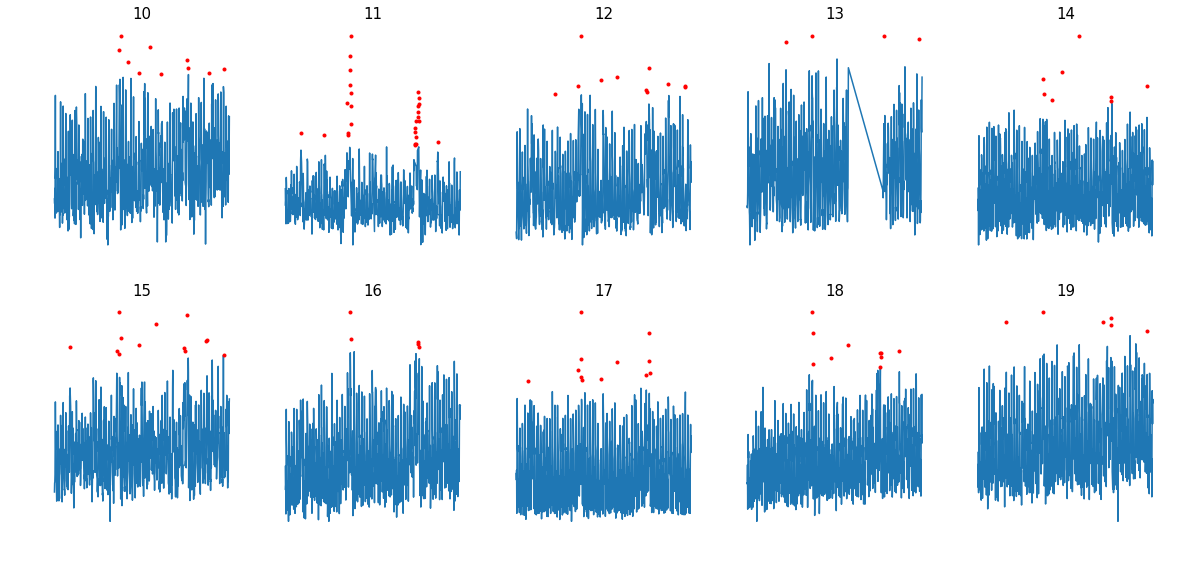

In [9]:
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(10,no_stores_to_check+10):
    stor = i

    # Normal sales
    X1 = data.loc[(data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == False)]
    y1 = data.loc[ (data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == False)]['Sales']

    # Outliers
    X2 = data.loc[(data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == True)]
    y2 = data.loc[ (data['Store'] == stor) & (data['Open'] == 1) & (data['Outlier'] == True)]['Sales']

    Xt = data.loc[(data['Store'] == stor)]
    
    plt.subplot(10,5,i-9)
    plt.plot(X1['Date'], y1, '-' )
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i,fontsize = 15)
    plt.axis('off')

plt.xlabel('test')
plt.ylabel('test')
plt.show()

对店铺特征信息进行整理，并增加几个特征

In [142]:
#把数据中竞争对手开业时间转换成一个时间特征。
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan


#把数据中促销2开始的星期转换成开始的日子是一年中的第几天   
def Promo2BeginDay(row):
    try:
        Day = 1
        Week = int(row['Promo2SinceWeek'])
        DateDayOfYear = 7*(Week-1)+1
        return DateDayOfYear
    except:
        return np.nan



#把促销2的月份转换为数字    
promo2_intervals = {'Jan,Apr,Jul,Oct' : (1,4,7,10),
                    'Feb,May,Aug,Nov' : (2,5,8,11),
                    'Mar,Jun,Sept,Dec' :(3,6,9,12),
                    np.nan : np.nan

                   }    

#开始转换信息
store_feature['CompetitionOpenInt'] = store_feature.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)
store_feature['Promo2BeginDay'] = store_feature.apply(Promo2BeginDay,axis = 1)
store_feature['PromoInterval'] = store_feature['PromoInterval'].apply(lambda x: promo2_intervals[x])
#store_feature['CompetitionDistance'] = store_feature['CompetitionDistance'].apply(lambda x:Feature_Nomalization(x,'CompetitionDistance'))
store_feature["StoreType"] = store_feature["StoreType"].map({'a':0, 'b':1, 'c' :2, 'd':3})
store_feature["Assortment"] = store_feature["Assortment"].map({'a':0, 'b':1, 'c' :2})

#删除此表中无用的信息
storefeature_columns_to_drop = ['CompetitionOpenSinceMonth','Promo2SinceWeek']
store_feature = store_feature.drop(storefeature_columns_to_drop, axis = 1)


#为店铺增加几个特征
store_data_sales = data[data['Outlier'] == 0].groupby([data['Store']])['Sales'].sum()
store_data_customers = data[data['Outlier'] == 0].groupby([data['Store']])['Customers'].sum()
store_data_open = data[data['Outlier'] == 0].groupby([data['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
#store_data_customers_per_day = store_data_customers / store_data_open
#store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day


store_feature = pd.merge(store_feature, store_data_sales_per_day.reset_index(name='SalesPerDay'), 
                         how='left', on=['Store'])
'''
store_feature = pd.merge(store_feature, store_data_customers_per_day.reset_index(name='CustomersPerDay'), 
                         how='left', on=['Store'])
store_feature = pd.merge(store_feature, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), 
                        how='left', on=['Store'])
'''
store_feature.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2BeginDay,SalesPerDay
0,1,2,0,1270.0,2008.0,0,NaN,NaN,1220227200000000000,NaN,4700.459635
1,2,0,0,570.0,2007.0,1,2010.0,"(1, 4, 7, 10)",1193875200000000000,85.0,4899.493557
2,3,0,0,14130.0,2006.0,1,2011.0,"(1, 4, 7, 10)",1164931200000000000,92.0,6901.818065
3,4,2,2,620.0,2009.0,0,NaN,NaN,1251763200000000000,NaN,9493.392950
4,5,0,0,29910.0,2015.0,0,NaN,NaN,1427846400000000000,NaN,4632.457956


两表合并前，对销售历史数据的日期进行处理，方便合并后的计算。

In [143]:

#对日期进行处理
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x: x.month)
data['DateDayOfYear'] = data['Date'].apply(lambda x: x.dayofyear)

data['DateInt'] = data['Date'].astype(np.int64)


data['SalesLog']  = np.log1p(data['Sales'])


data.head(5)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Outlier,Year,Month,DateDayOfYear,DateInt,SalesLog
1016447,353,2,2013-01-01,3139,820,1,0,1,1,False,2013,1,1,1356998400000000000,8.051978
1016429,335,2,2013-01-01,2401,482,1,0,1,1,False,2013,1,1,1356998400000000000,7.784057
1016606,512,2,2013-01-01,2646,625,1,0,1,1,False,2013,1,1,1356998400000000000,7.881182
1016588,494,2,2013-01-01,3113,527,1,0,1,1,False,2013,1,1,1356998400000000000,8.043663
1016624,530,2,2013-01-01,2907,532,1,0,1,1,False,2013,1,1,1356998400000000000,7.975221


合并两张表的信息,并新建promo2_today（表明这天是否有促销2）这个特征

In [144]:
full_data = pd.merge(data, store_feature, how = 'left', on = ['Store'])

#通过销售日日期与促销2的信息，判断当天是否有促销2
def promo2_today(row):
    if row['Promo2'] == 1 and row['Year'] >= row['Promo2SinceYear']\
    and row['Month'] in row['PromoInterval']:
        return 1
    else:
        return 0



    
full_data['promo2_today'] = full_data.apply(promo2_today, axis = 1)

full_data.to_csv('full_data.csv')
full_data.head(5)



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Outlier,...,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2BeginDay,SalesPerDay,promo2_today
0,353,2,2013-01-01,3139,820,1,0,1,1,False,...,1,900.0,2001.0,1,2013.0,"(2, 5, 8, 11)",978307200000000000,92.0,5571.336254,0
1,335,2,2013-01-01,2401,482,1,0,1,1,False,...,0,90.0,2001.0,1,2013.0,"(1, 4, 7, 10)",978307200000000000,211.0,13277.168085,1
2,512,2,2013-01-01,2646,625,1,0,1,1,False,...,1,590.0,2001.0,1,2013.0,"(3, 6, 9, 12)",978307200000000000,29.0,5422.256552,0
3,494,2,2013-01-01,3113,527,1,0,1,1,False,...,0,1260.0,2011.0,0,NaN,NaN,1306886400000000000,NaN,7636.980851,0
4,530,2,2013-01-01,2907,532,1,0,1,1,False,...,2,18160.0,2001.0,0,NaN,NaN,978307200000000000,NaN,4589.805556,0


## 数据可视化
读取一个店铺一个月的销量，获得一个直观印象。销量大概是以周为时间单位波动的

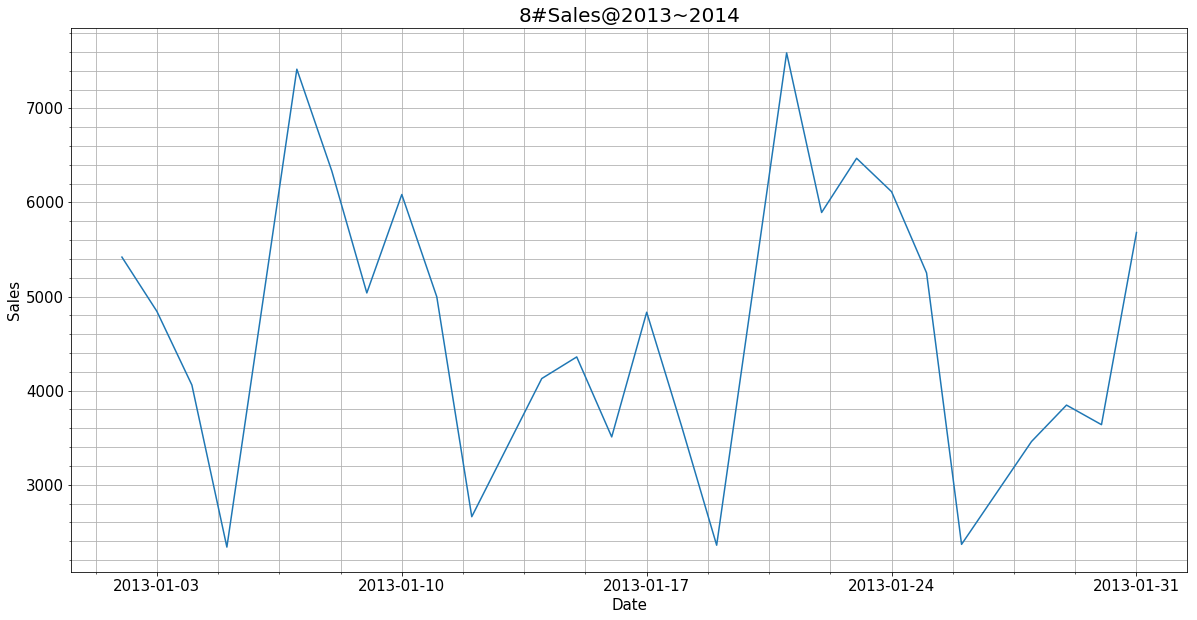

In [13]:
plt.rcParams["figure.figsize"] = [20,10]
stor = 8

X1 = data.loc[(data['Store'] == stor) & (data['Open'] == 1)&(data['Date']<'2013-2-1')]
y1 = data.loc[(data['Store'] == stor) & (data['Open'] == 1)&(data['Date']<'2013-2-1')]['Sales']
Xt = data.loc[(data['Store'] == stor)]    
plt.plot(X1['Date'], y1, '-', )
plt.minorticks_on()
plt.grid(True, which='both')

plt.title('8#Sales@2013~2014', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()


节假日、促销这些特征对销售量确实有一定影响，但有些影响不是特别大

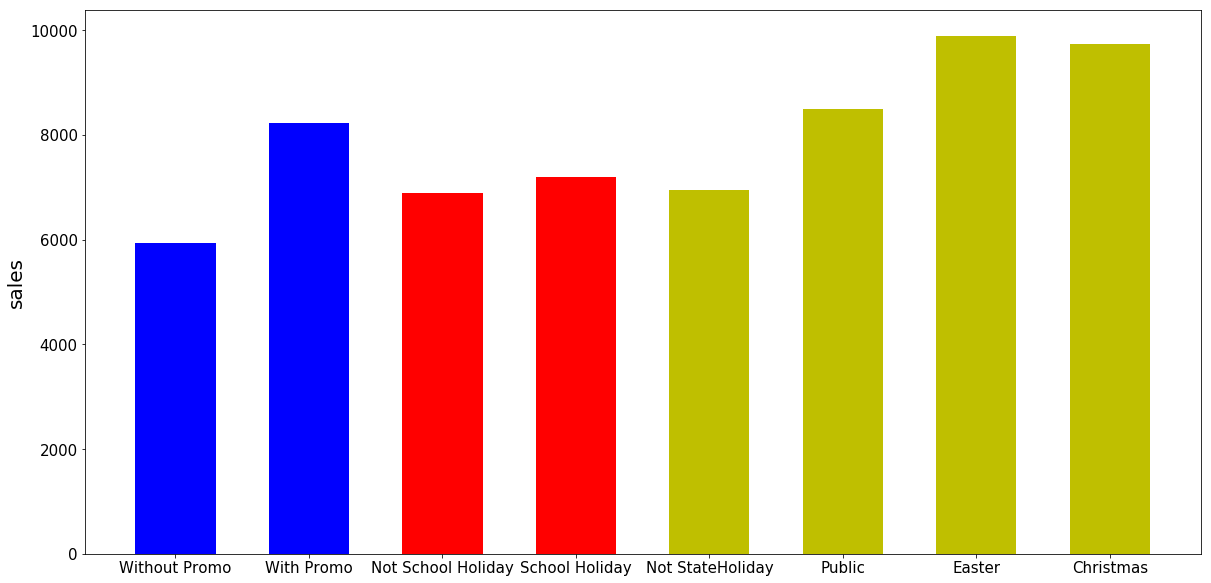

In [14]:
average_sales_pro1 = data.groupby('Promo')['Sales'].mean()
average_sales_schoolholiday = data.groupby('SchoolHoliday')['Sales'].mean()
average_sales_holiday = data.groupby('StateHoliday')['Sales'].mean()
plt.bar(average_sales_pro1.index, average_sales_pro1,width = 0.6, align = 'center' , color = 'b')
plt.bar(average_sales_schoolholiday.index+2,average_sales_schoolholiday,width = 0.6, align = 'center', color = 'r')
plt.bar(average_sales_holiday.index+4, average_sales_holiday,width = 0.6, align = 'center', color = 'y')
plt.xticks(range(8), ('Without Promo', 'With Promo', 'Not School Holiday', 'School Holiday', 'Not StateHoliday','Public', 'Easter', 'Christmas'),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('sales', fontsize = 20)
plt.show()

周几对销量也有很大影响

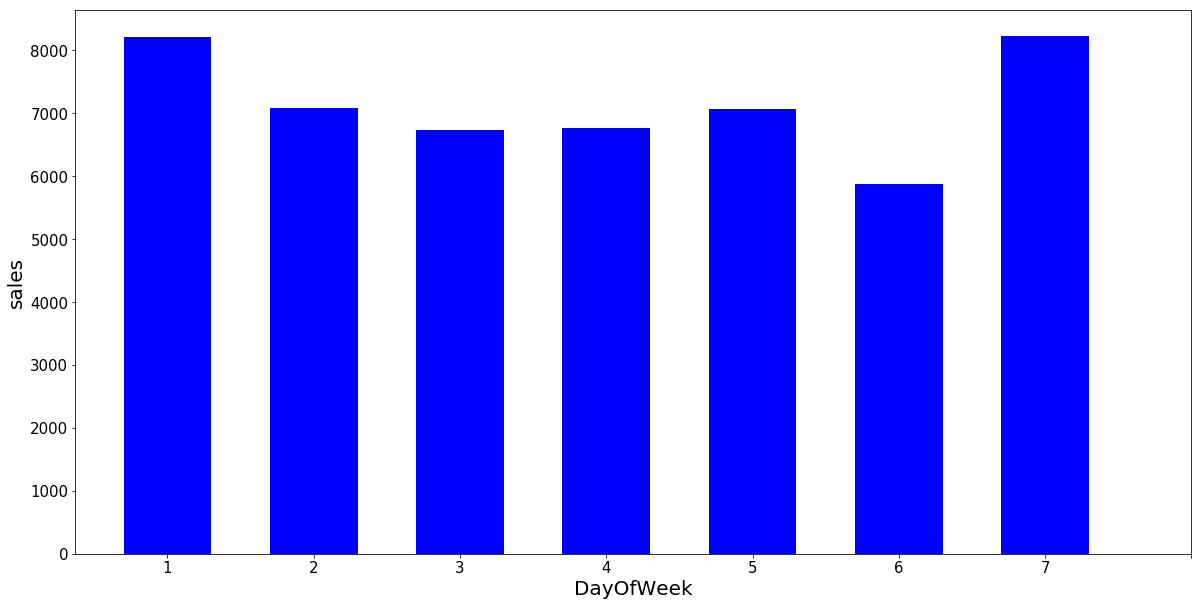

In [15]:
average_sales_weekday = data.groupby('DayOfWeek')['Sales'].mean()
plt.bar(average_sales_weekday .index-1, average_sales_weekday,width = 0.6, align = 'center' , color = 'b')
plt.xticks(range(8), (average_sales_weekday .index),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('sales', fontsize = 20)
plt.xlabel('DayOfWeek', fontsize = 20)
plt.show()

查看店铺类型对销量的影响情况

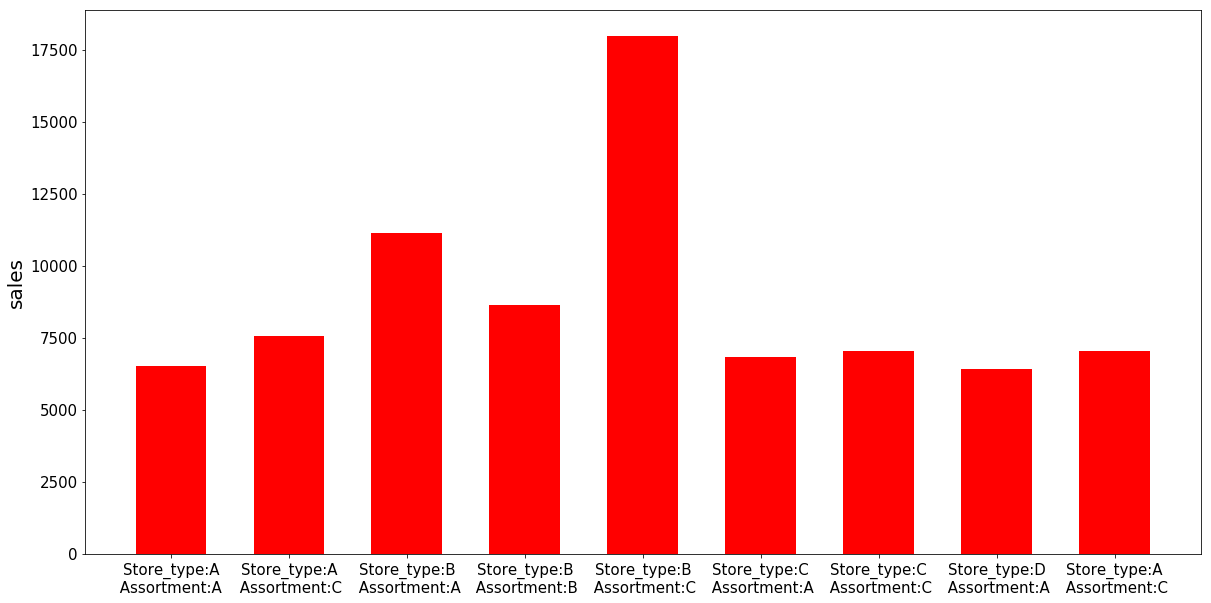

In [16]:
full_data = pd.read_csv('full_data.csv') 
full_data = full_data[full_data['Open'] == 1]
plt.rcParams["figure.figsize"] = [20,10]
a = full_data.groupby(['StoreType','Assortment'])['Sales'].mean()
plt.bar(range(9),a,width = 0.6, align = 'center', color = 'r')
index = ('Store_type:A\n Assortment:A ', 'Store_type:A\n Assortment:C', 'Store_type:B\n Assortment:A', 'Store_type:B\n Assortment:B',
        'Store_type:B\n Assortment:C', 'Store_type:C\n Assortment:A', 'Store_type:C\n Assortment:C', 
         'Store_type:D\n Assortment:A', 'Store_type:A\n Assortment:C',)
plt.xticks(range(9), index, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('sales', fontsize = 20)
plt.show()

展示各个特征之间的相关性，先删除类别数据和我创建的特征以及其他不方便分析的信息。

In [17]:
full_data = pd.read_csv('full_data.csv') 
full_data = full_data[full_data['Open'] == 1]
useful_columns = ['Sales','Customers', 'Promo','SchoolHoliday','StateHoliday',
                      'promo2_today','CompetitionDistance', 'DateInt', 'CompetitionOpenInt', ]
test_data = full_data[useful_columns]

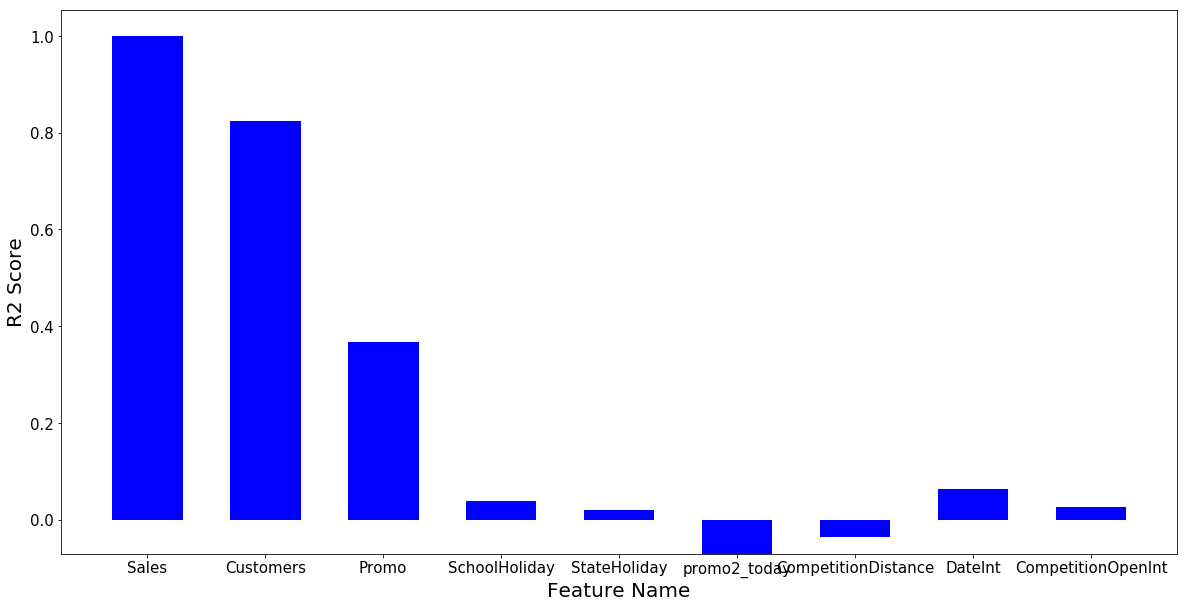

In [30]:
test_data.corr().iloc[0].index
plt.bar(range(9), test_data.corr().iloc[0],width = 0.6, align = 'center' , color = 'b')
plt.xticks(range(9), (test_data.corr().iloc[0].index),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('R2 Score', fontsize = 20)
plt.xlabel('Feature Name', fontsize = 20)
plt.show()

## 基准模型
我打算用各店的平均销售额作为我预测的基准，最后算出得分为0.3937

In [145]:
def performance_metric(y_pred,y_true): 
    y_true = y_true.astype(float)
    y_pred = y_pred.astype(float)
    y_true = np.exp(y_true) - 1
    y_pred = np.exp(y_pred) - 1
    return   (np.mean(((y_true-y_pred)/y_true)**2)) **0.5

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)

    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe



## 训练
接下来就要用数据进行训练了.训练前最后进行数据整理，删除无用信息。
首先使用随机森林算法进行.


In [185]:
#只选出开业和数据正常的数据
full_data = pd.read_csv('full_data.csv',
                        parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
                       ) 
full_data = full_data.drop('Unnamed: 0', axis = 1)


newdata = full_data[full_data['Open'] == 1]


    
newdata = newdata.loc[~(newdata['Outlier'] == True)]


newdata_columns_to_drop = ['Promo2', 'Promo2SinceYear', 
                            'PromoInterval', 'CompetitionOpenSinceYear', 
                            'Promo2BeginDay','Customers',
                           'Outlier'      ,'Open' 
                           ]

newdata = newdata.drop(newdata_columns_to_drop, axis = 1)

newdata.head(5)


,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,DateDayOfYear,DateInt,SalesLog,StoreType,Assortment,CompetitionDistance,CompetitionOpenInt,SalesPerDay,promo2_today
0,353,2,2013-01-01,3139,0,1,1,2013,1,1,1356998400000000000,8.051978,1,1,900.0,978307200000000000,5571.336254,0
1,335,2,2013-01-01,2401,0,1,1,2013,1,1,1356998400000000000,7.784057,1,0,90.0,978307200000000000,13277.168085,1
2,512,2,2013-01-01,2646,0,1,1,2013,1,1,1356998400000000000,7.881182,1,1,590.0,978307200000000000,5422.256552,0
3,494,2,2013-01-01,3113,0,1,1,2013,1,1,1356998400000000000,8.043663,1,0,1260.0,1306886400000000000,7636.980851,0
4,530,2,2013-01-01,2907,0,1,1,2013,1,1,1356998400000000000,7.975221,0,2,18160.0,978307200000000000,4589.805556,0


把数据分为训练和验证集

In [186]:
train_data = newdata
X_all = train_data.drop(['Sales','SalesLog'], axis = 1)
Y_all = train_data['SalesLog']

X_train = X_all.iloc[:-84*1115]
Y_train = Y_all.iloc[:-84*1115]

X_valid = X_all.iloc[-84*1115:-42*1115]
Y_valid = Y_all.iloc[-84*1115:-42*1115]

X_test = X_all[-42*1115:]
Y_test = Y_all[-42*1115:]

x_train = X_train.drop(['Date'],axis = 1)
x_valid = X_valid.drop(['Date'],axis = 1)
x_test = X_test.drop(['Date'],axis = 1)
y_train = Y_train
y_valid = Y_valid
y_test = Y_test

计算基准模型得分

In [148]:
a = ['SalesLog',"Store"]
predict_data = full_data[a]
#计算每个店铺的销售平均值 
average_sales_store = predict_data.groupby('Store')['SalesLog'].mean()

def get_sales(row):
    return average_sales_store.loc[row['Store']]


#把预测数据里的销售值替代为该店铺的平均销售值
aa = x_test
aa['Predict_SalesLog'] = predict_data.apply(get_sales, axis = 1)

y_true = y_test
y_pred = aa['Predict_SalesLog'].values

base_score = rmspe(y_pred,y_true)
print ("Base model score is : {:,.6f}".format(base_score))

Base model score is : 0.295140


### 随机森林
开始训练并打印得分

In [187]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state= seed)

  
model.fit(x_train, y_train)
Y_pred = model.predict(x_train)
a = rmspe(y_train,Y_pred)
Y_pred = model.predict(x_valid)
b = rmspe(y_valid, Y_pred)


print ("RandomForest Train score is : {:,.6f}".format(a))
print ("RandomForest Validate score is : {:,.6f}".format(b))

RandomForest Train score is : 0.046671
RandomForest Validate score is : 0.147733


特征重要性可视化

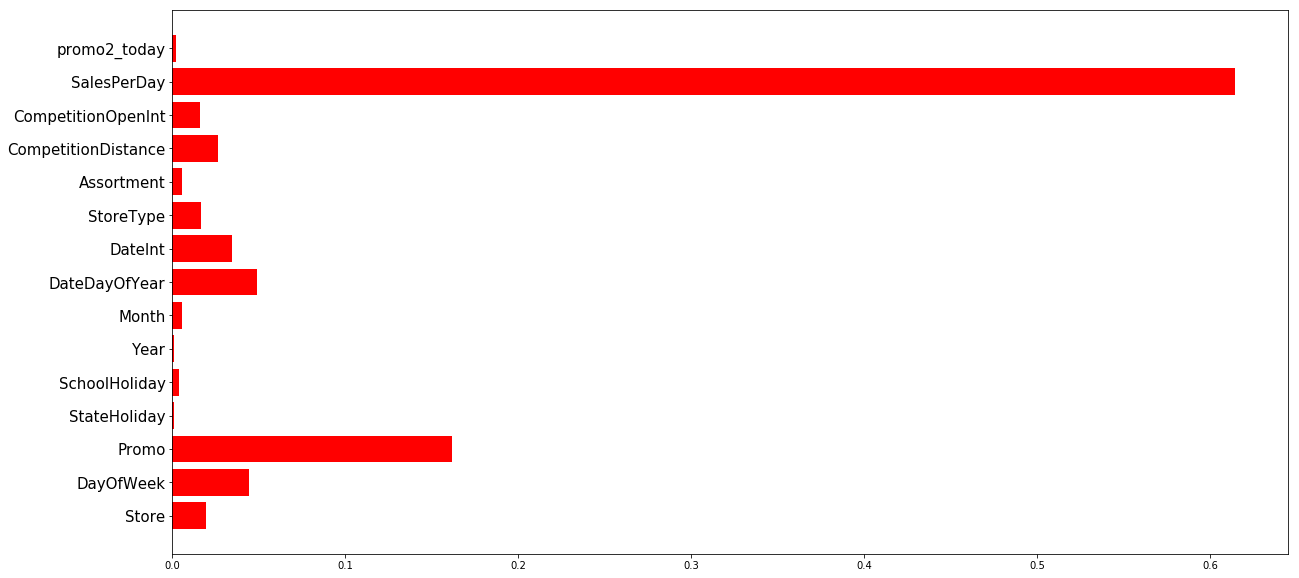

In [158]:
a = model.feature_importances_
b = a
X = train_data.drop(['Sales','SalesLog'], axis = 1)
index = X_train.drop(['Date'],axis = 1).columns
plt.rcParams["figure.figsize"] = [20,10]
plt.barh(range(len(b)),b,align = 'center', color = 'r')
plt.yticks(range(len(b)), index, fontsize = 15)
plt.show()

使用网格搜索技术寻找更佳参数

In [193]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(random_state= seed)
parameters = {'n_estimators' :[10,20], 'min_samples_split' : [2,5,10]}
grid_obj = GridSearchCV(estimator=model ,param_grid=parameters, cv=3)
grid_obj = grid_obj.fit(x_train, y_train)
bst= grid_obj.best_estimator_
best_parameter = grid_obj.best_params_

In [195]:
Y_pred = bst.predict(x_valid)
b = rmspe(y_valid, Y_pred)
print ("RandomForest Valid score after tunning is : {:,.6f}".format(b))
Y_pred = bst.predict(x_test)
c = rmspe(y_test, Y_pred)
print ("RandomForest Test score after tunning is : {:,.6f}".format(c))
print ('Best parameter is:')
print (best_parameter)

RandomForest Valid score after tunning is : 0.140956
RandomForest Test score after tunning is : 0.127131
Best parameter is:
{'min_samples_split': 10, 'n_estimators': 20}


预测结果可视化

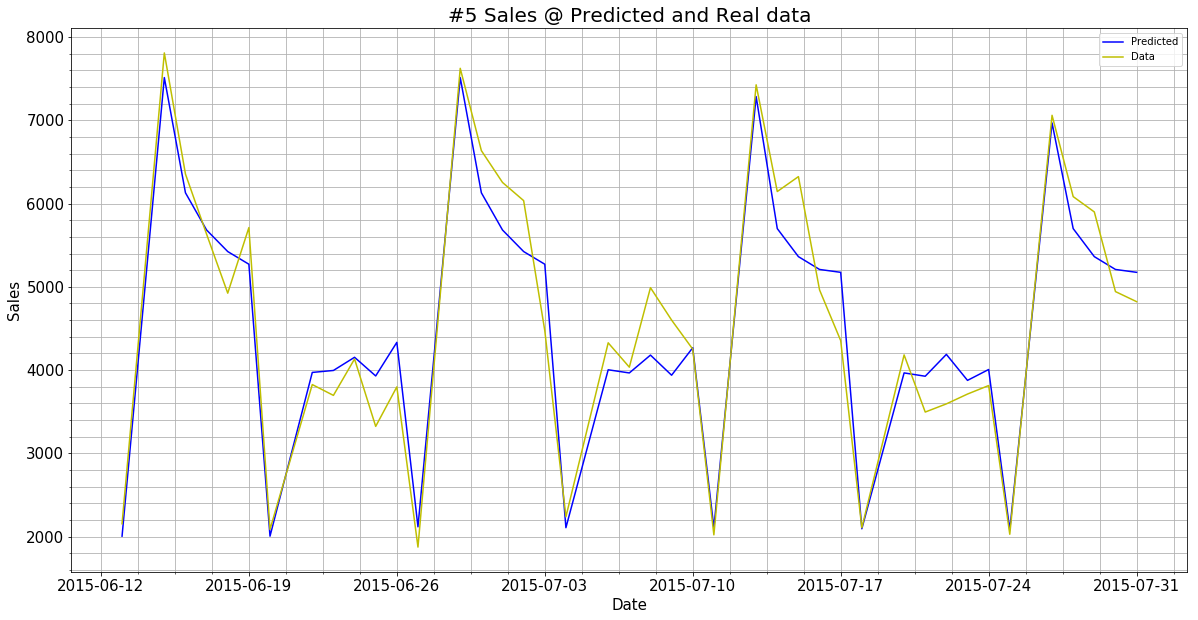

In [188]:
store_num = 5
X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = model.predict(X_test.drop(['Date'],axis = 1)[(X_test['Store'] == store_num)].values)
y1 = np.exp(y1)-1
y2 = np.exp(y2)-1
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

### XGBoost
在进行训练前，删除无用数据

In [159]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_valid, y_valid)
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [160]:

param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed}

plst = param.items()

bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmspe:0.996862	test-rmspe:0.997079
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmspe:0.140582	test-rmspe:0.139348
[500]	train-rmspe:0.111834	test-rmspe:0.131841
[750]	train-rmspe:0.105599	test-rmspe:0.131934
Stopping. Best iteration:
[617]	train-rmspe:0.108137	test-rmspe:0.131279



In [161]:
ypred = xgb.DMatrix(x_test)
ypred = bst1.predict(ypred)
a=rmspe(y_test .values, ypred)
print ("XGBoost Test score is : {:,.6f}".format(a))

XGBoost Test score is : 0.140674


预测结果可视化

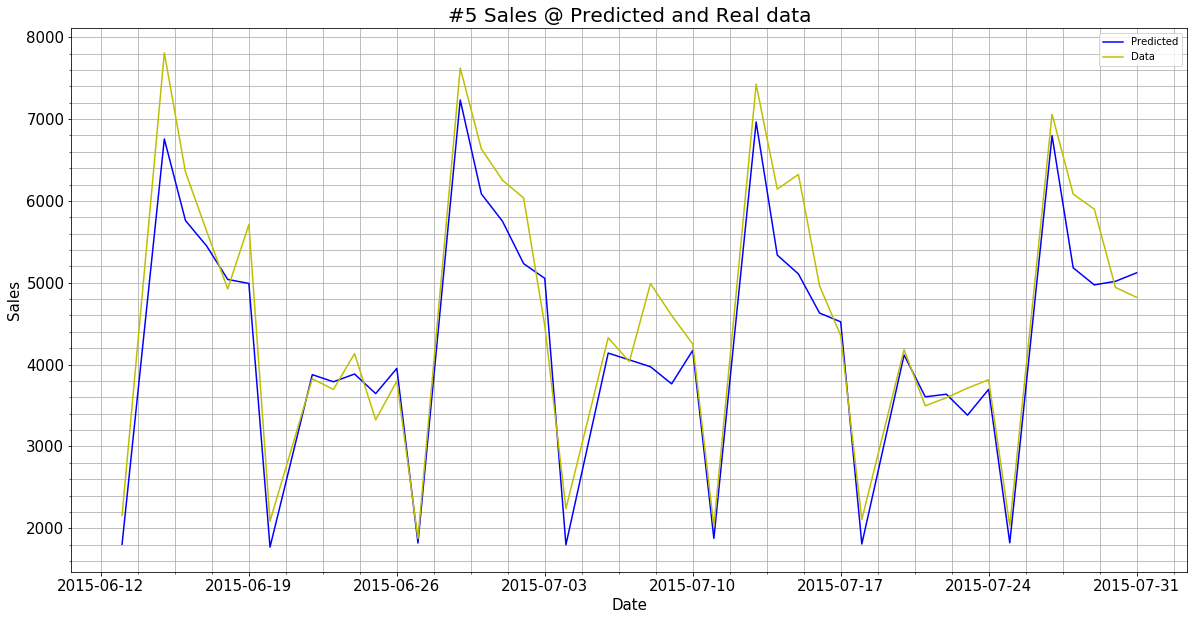

In [189]:
store_num = 5
ypred = xgb.DMatrix(x_test.loc[x_test['Store'] == store_num])
X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = bst1.predict(ypred)
y1 = np.exp(y1)-1
y2 = np.exp(y2)-1
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

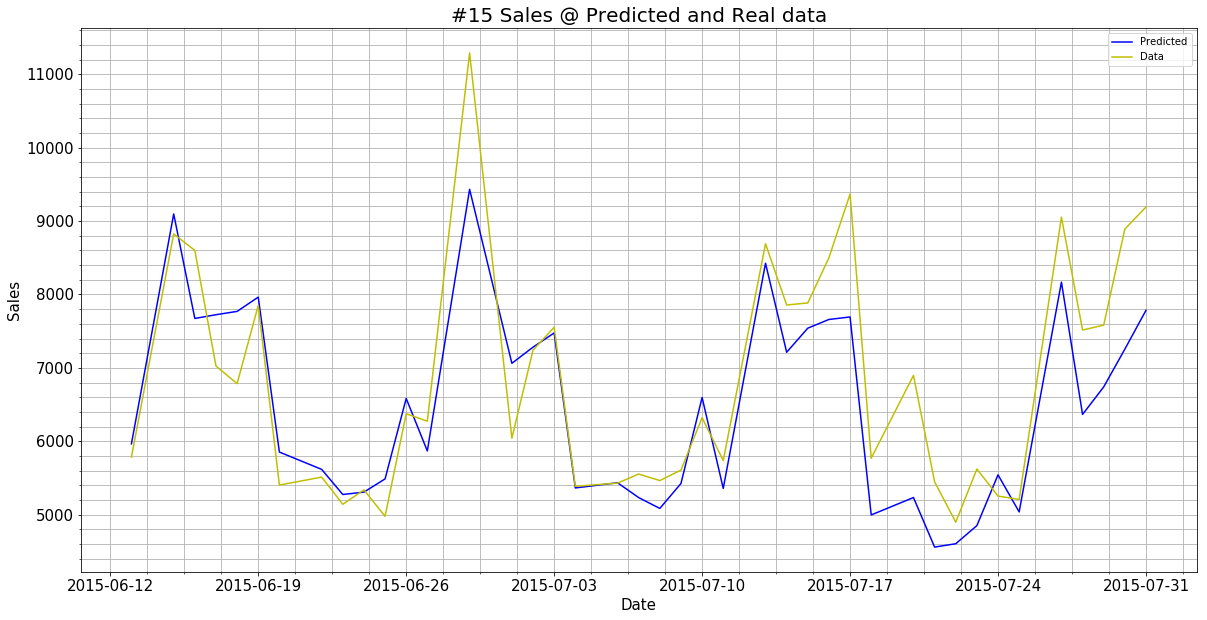

In [190]:
store_num = 15
ypred = xgb.DMatrix(x_test.loc[x_test['Store'] == store_num])

X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = bst1.predict(ypred)
y1 = np.exp(y1)-1
y2 = np.exp(y2)-1
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

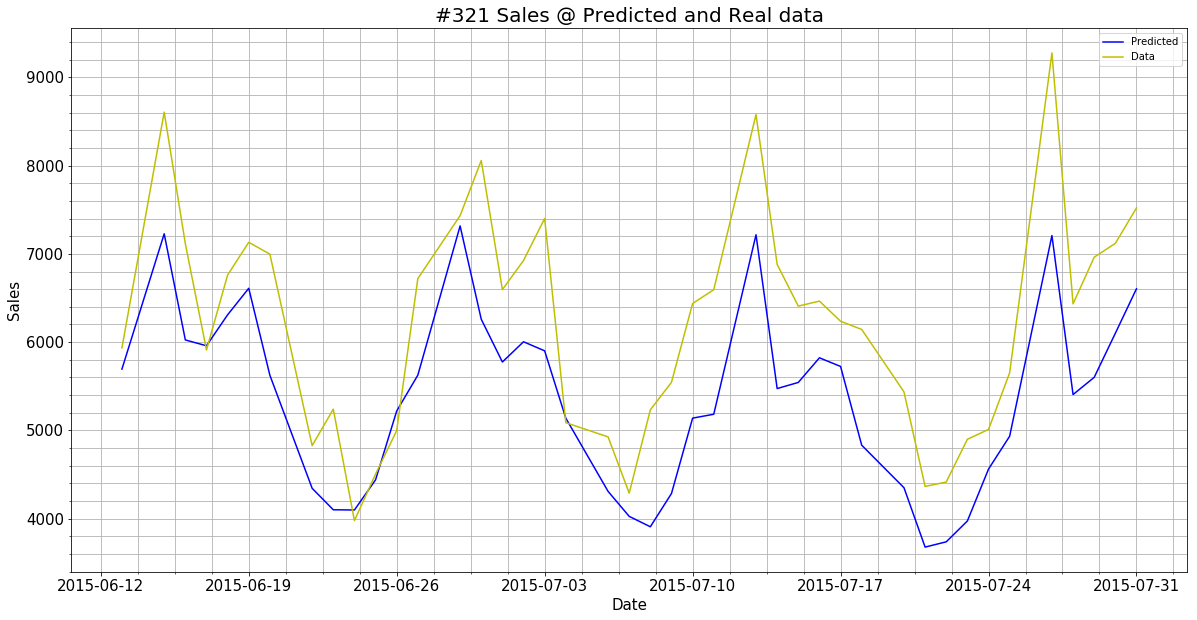

In [191]:
store_num = 321
ypred = xgb.DMatrix(x_test.loc[x_test['Store'] == store_num])

X1 = X_test['Date'].loc[(X_test['Store'] == store_num) ]
y1 = Y_test.loc[(X_test['Store'] == store_num)]
y2 = bst1.predict(ypred)
y1 = np.exp(y1)-1
y2 = np.exp(y2)-1
Xt = X_test.loc[(X_test['Store'] == store_num)]    
plt.plot(X1, y2, '-', color = 'b', label = 'Predicted')
plt.plot(X1, y1, '-', color = 'y', label = 'Data')
plt.legend(loc = 'upper right')
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('#{:,.0f} Sales @ Predicted and Real data'.format(store_num), fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.show()

XGBoost特征重要性

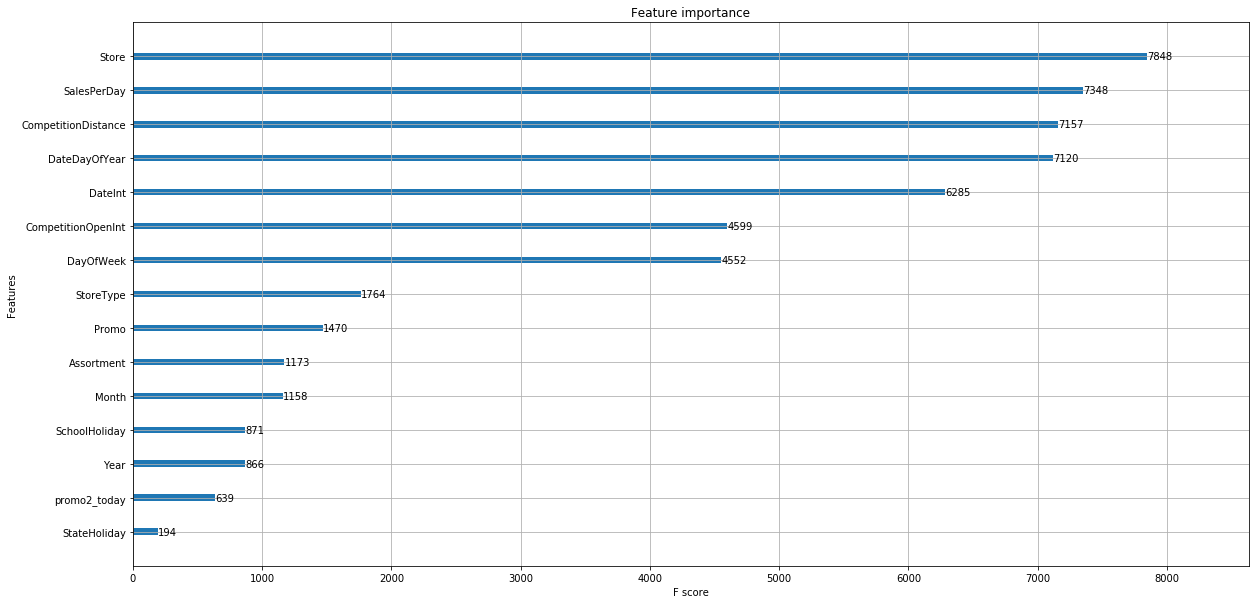

In [192]:
xgb.plot_importance(bst1)  
plt.show()  

### 前向神经网络
由于神经网络对数据要求不一样，所以还是需要重新处理一下数据。在进行训练前，删除无用数据，并且对数据进行归一化。

In [162]:
full_data = pd.read_csv('full_data.csv',
                        parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
                       )  
full_data = full_data.drop('Unnamed: 0', axis = 1)
newdata = full_data[full_data['Open'] == 1]


newdata = newdata.loc[~(newdata['Outlier'] == True)]


newdata_columns_to_norm = ['CompetitionDistance','SalesPerDay']
newdata[newdata_columns_to_norm] = newdata[newdata_columns_to_norm].apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))


newdata_columns_to_drop = ['Promo2', 'Promo2SinceYear', 
                            'PromoInterval', 'CompetitionOpenSinceYear', 
                             'Promo2BeginDay','Customers', 'CompetitionOpenInt',
                           'Year','Month','Open', 'Outlier'   ,'Date'    ,'Store'  ,'DateInt'   
                           ]

newdata = newdata.drop(newdata_columns_to_drop, axis = 1)

#进行独热编码

newdata = pd.get_dummies(newdata,columns = ['StateHoliday','StoreType', 'Assortment','DayOfWeek'])

newdata.to_csv('newdata.csv')
newdata.head(5)

,Sales,Promo,SchoolHoliday,DateDayOfYear,SalesLog,CompetitionDistance,SalesPerDay,promo2_today,StateHoliday_0,StateHoliday_1,...,Assortment_0,Assortment_1,Assortment_2,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,3139,0,1,1,8.051978,0.011864,0.151137,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,2401,0,1,1,7.784057,0.001186,0.553882,1,0,1,...,1,0,0,0,1,0,0,0,0,0
2,2646,0,1,1,7.881182,0.007777,0.143345,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,3113,0,1,1,8.043663,0.016610,0.259098,0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,2907,0,1,1,7.975221,0.239388,0.099837,0,0,1,...,0,0,1,0,1,0,0,0,0,0


创建训练集、验证集、测试集

In [163]:
newdata = pd.read_csv("newdata.csv")
train_data = newdata.drop('Unnamed: 0', axis = 1)

X_all = train_data.drop(['Sales','SalesLog'], axis = 1).values
Y_all = train_data['SalesLog'].values
X_train = X_all[:-84*1115]
Y_train = Y_all[:-84*1115]

X_valid = X_all[-84*1115:-42*1115]
Y_valid = Y_all[-84*1115:-42*1115]

X_test = X_all[-42*1115:]
Y_test = Y_all[-42*1115:]

train_data.head(5)

,Sales,Promo,SchoolHoliday,DateDayOfYear,SalesLog,CompetitionDistance,SalesPerDay,promo2_today,StateHoliday_0,StateHoliday_1,...,Assortment_0,Assortment_1,Assortment_2,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,3139,0,1,1,8.051978,0.011864,0.151137,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,2401,0,1,1,7.784057,0.001186,0.553882,1,0,1,...,1,0,0,0,1,0,0,0,0,0
2,2646,0,1,1,7.881182,0.007777,0.143345,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,3113,0,1,1,8.043663,0.016610,0.259098,0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,2907,0,1,1,7.975221,0.239388,0.099837,0,0,1,...,0,0,1,0,1,0,0,0,0,0


神经网络的评价函数(原有的不可用，因为需要写成张量形式)

In [171]:
from keras import backend as K
def performance_metric_neu(y_true, y_pred): 
    y_true = K.exp(y_true) - 1
    y_pred = K.exp(y_pred) - 1
    y = K.sqrt((K.mean(K.square((y_true-y_pred)/y_true))))
    return 100*y



创建网络

In [172]:
seed = 4
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import initializers

model = Sequential()
model.add(Dense(56, input_dim=X_train.shape[1], kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed), activation='relu'))
model.add(Dense(56, kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed), activation='relu'))
model.add(Dense(56, kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed), activation='relu'))
model.add(Dense(1, kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev = 0.01, seed = seed)))
model.summary()
model.compile(loss=performance_metric_neu, optimizer='adam', metric = performance_metric_neu)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 56)                1400      
_________________________________________________________________
dense_14 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_15 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 57        
Total params: 7,841.0
Trainable params: 7,841
Non-trainable params: 0.0
_________________________________________________________________


开始训练

In [173]:
from keras.callbacks import ModelCheckpoint  ,EarlyStopping, ReduceLROnPlateau


epochs = 300

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
stopping = EarlyStopping(monitor = 'val_loss',patience = 15, verbose = 1, mode = 'auto')
rd =  ReduceLROnPlateau(verbose = 1,patience = 5, factor = 0.5)
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          epochs=epochs, batch_size=256, callbacks=[checkpointer,rd], verbose=1)



/home/markus/.conda/envs/aind-dog/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 737699 samples, validate on 46830 samples
Epoch 1/300
737699/737699 [==============================] - 7s - loss: 97.0420 - val_loss: 99.8220
Epoch 2/300
737699/737699 [==============================] - 7s - loss: 36.5242 - val_loss: 23.8763
Epoch 3/300
737699/737699 [==============================] - 7s - loss: 28.4846 - val_loss: 96.9481
Epoch 4/300
737699/737699 [==============================] - 7s - loss: 29.1549 - val_loss: 20.4553
Epoch 5/300
737699/737699 [==============================] - 7s - loss: 27.3409 - val_loss: 22.5956
Epoch 6/300
737699/737699 [==============================] - 7s - loss: 26.8150 - val_loss: 19.7019
Epoch 7/300
737699/737699 [==============================] - 8s - loss: 24.1962 - val_loss: 18.5431
Epoch 8/300
737699/737699 [==============================] - 8s - loss: 23.3627 - val_loss: 19.0992
Epoch 9/300
737699/737699 [==============================] - 7s - loss: 23.8222 - val_loss: 18.1139
Epoch 10/300
737699/737699 [=====================

KeyboardInterrupt: 

查看模型得分

In [174]:
model.load_weights('weights.best.hdf5')
pred = model.predict(X_train)
a = performance_metric(pred.flatten(), Y_train)
print ("Neural Network Train score is : {:,.6f}".format(a))
model.load_weights('weights.best.hdf5')
pred = model.predict(X_valid)
a = performance_metric(pred.flatten(), Y_valid)
print ("Neural Network Valid score is : {:,.6f}".format(a))
model.load_weights('weights.best.hdf5')
pred = model.predict(X_test)
a = performance_metric(pred.flatten(), Y_test)
print ("Neural Network Test score is : {:,.6f}".format(a))

/home/markus/.conda/envs/aind-dog/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Neural Network Train score is : 0.218131
Neural Network Valid score is : 0.179276
Neural Network Test score is : 0.172958
